# BH, Halo Accretion Rates & Occurrence of AGN
## Missy McIntosh, Surhud More, John Silverman
### April-June 2016, IPMU

## Introduction

We investigate two questions: 
1. Does the baryonic accretion rate of black holes in cD galaxies relate to the dark matter halo accretion rate for galaxy clusters? 
2. Does the occurence of AGN relate to the accretion rate of black holes or dark matter halos? 

We begin by matching two photometric catalogs of galaxy RA & Dec locations with a spectroscopic catalog that informs us of the black hole accretion rate for each galaxy. This was done using the best match Sky algorithm in TOPCAT, with a tolerance of 1 arcsecond. The two photometric catalogs vary in dark matter halo accretion rate, so we compare the relation between BH accretion rate and DMH accretion rate between the two. 

We then search for nearby galaxies with spectroscopic data within 10 Mpc of each galaxy in the catalogs. We add the number of satellite galaxies found into bins as a function of radius from the central galaxy. Each spectra is tagged as a Seyfert, Liner, Composite, etc., for each galaxy. We compare the type of galaxy surrounding each galaxy with the galaxy cluster's dark matter halo accretion rate. 

## Method

We convert from RA/DEC in degrees to cartesian coordinates in radians on a unit sphere and then apply a redshift cut based on radial velocity.  We use a KDTree for nearest neighbor matches. We use each photometric galaxy as a central, "seed," galaxy to search in a spherical radius around. We use the default cosmological parameters found in AUM (https://github.com/surhudm/aum/blob/master/README.md) for calculating radii at various redshifts.


In [1]:
import glob
import os
from astropy.io import fits
import sys
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import pandas as pd
from tqdm import * 
import cython

%matplotlib inline
%pylab inline
%load_ext Cython
pylab.rcParams['figure.figsize'] = (15, 7);

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [ ]:
%%cython
import numpy as np
import pandas as pd
from astropy.table import Table
from scipy import spatial
import cosmology as cc
a = cc.cosmology()


def tocartesian(ra_in_deg, dec_in_deg):
    """
    (x,y,z) = tocartesian(ra_in_deg, dec_in_deg)
    
    Convert RA and DEC coordinates given 
    in degrees into Cartesian points (x,y,z)
    on unit circle
    """
    
    ra = np.radians(ra_in_deg)
    dec = np.radians(dec_in_deg)
    x = np.cos(ra) * np.cos(dec)
    y = np.sin(ra) * np.cos(dec)
    z = np.sin(dec)
    
    return((x,y,z))


def angular_search_radius(radius_in_mpc,z):
    """
    angular_radius = angular_search_radius(radius_in_mpc,z)
    
    Return the comoving distance as a function of redshift, using default cosmological parameters
    in AUM (https://github.com/surhudm/aum/blob/master/README.md)
    """
    return(radius_in_mpc/a.Dcofz(z))


def redshift_cut(df,angular_matched_indices, z, radial_velocity):
    """
    cut_indices = redshift_cut(df,angular_matched_indices, z, radial_velocity)
    
    Return indices that are constrained by np.abs((C*delta_z)/(1+z)) < radial_velocity
    """
    
    # if there were no angular matches, then there is nothing to cut out
    if len(angular_matched_indices) == 0:
            return([])
        
    # retrieve redshifts for the matched galaxies    
    z_arr = [df.iloc[k]['REDSHIFT'] for k in angular_matched_indices]
    C = 3*10**5 # km/s
    
    # if the cut quantity is less than the radial velocity, keep the galaxy
    cut_mask = []
    for z_i in z_arr:
        delta_z = z - z_i
        cut = np.abs((C*delta_z)/(1+z))
        cut_mask.append(cut < radial_velocity)
    cut_indices = [index for (index, mask) in zip(angular_matched_indices, cut_mask) if mask]
    
    
    # for every few iterations, print out the variables so I can debug
    rand = np.random.binomial(1, 0.01)
    if rand > 0:
        print("for rv {0}, {1}/{2} galaxies are kept; " 
              "last cut value is {3:.2f}".format(
               radial_velocity, len(cut_indices),len(angular_matched_indices), cut))
    
    return(cut_indices)



def getdistance(point, point_arr,z):
    """
    dists = getdistance(point, point_arr,z)
    
    Find the distance between two cartesian points on a unit sphere 
    and return it in Mpc using its redshift, using default cosmological parameters
    in AUM (https://github.com/surhudm/aum/blob/master/README.md)
    """
    
    # if there are no points, there is no distance to compute
    if len(point_arr) == 0:
        return([])
    
    # format the array of points and feed into np.lingalg.norm()
    points = np.tile(np.asarray(point), (len(point_arr),1))
    dists = list(map(np.linalg.norm, points - point_arr))
    
    # multiply distance in radians by comoving distance to get it in Mpc
    d_comoving = a.Dcofz(z)
    dists = [d_comoving*d for d in dists]
    
    return(dists)




def fits_coordinates_to_tree(fits_file):
    '''
    tree, data, df = fits_coordinates_to_tree(fits_file)
    
    Read in a tabular fits file to a cKDTree,
    return list of cartesian coordinates,
    and write out fits Table as a pandas dataframe. 
    '''
    
    table = Table.read(fits_file)
    arr = np.arange(len(table['RA'])*4.).reshape(len(table['RA']), 4)
    t = Table(arr, names=('RA', 'DEC', 'REDSHIFT', 'BPT'), dtype=('float', 'float', 'float', 'str'))
    t['DEC']=table['DEC']
    t['REDSHIFT']=table['REDSHIFT']
    t['BPT'] = table['BPT']
    t['RA'] = table['RA']
    df = t.to_pandas()
    
    data = list(map(tocartesian,df['RA'],df['DEC']))
    tree = spatial.cKDTree(data)
    
    return(tree, data, df)
        
    



def getneighbors(seed_df, tree_df, tree_coordinate_list, 
                 tree, mpc_search_radius, radial_velocity_limit):
    """
    indices, distances, types = getneighbors(seed_df, tree_df, tree_coordinate_list, 
                                             tree, mpc_search_radius, radial_velocity_limit)
                 
    Nearest neighbor query for a cKDTree, using a spherical search radius that depends on redshift
    and cosomological parameters, returning index and distance. Also retrieves the surrounding galaxy 
    types listed in the input table. Returns an array of arrays so if you were interested in one central
    galaxy in particular, you could find the surrounding galaxies for that single central galaxy index.
    
    Includes nearest neighbors whose distance is ~0.0
    
    Input
    ------
    seed_df                the pandas dataframe of galaxies you want to search a spherical area around
    tree_df                the pandas dataframe of galaxies populated in your search tree
    tree_coordinate_list   a list of cartesian coordinates for the galaxies populated in your search tree
    tree                   the cKDETree you want to search
    mpc_search_radius      the radius in Mpc for your search sphere around your seed galaxy
    radial_velocity_limit  the radial velocity variance cut (see help(redshift_cut))
    
    Output
    ------
    indices                array of arrays of indicies of the matched galaxies in the tree_df per seed galaxy
    distances              array of arrays of distances of the matched galaxies in the tree_df per seed galaxy
    types                  array of arrays of galaxy types (Seyfert, LINER, etc.) of the matched galaxes
                                                            in the tree_df per seed galaxy
    
    """

    indices = []
    distances = []
    types = []
    for i in np.arange(len(seed_df)):
        
        # select seed/central galaxy to search spherically around
        seed = seed_df.iloc[i]
        seed_z = seed['REDSHIFT']
        seed_coordinates = tocartesian(seed['RA_1'],seed['DEC_1'])
        
        # retrieve angularly matched coordinates in the tree
        # also apply a redshift cut for variance above some radial velocity
        angular_matched_indices = tree.query_ball_point(seed_coordinates,
                                                        angular_search_radius(mpc_search_radius,seed_z))
        redshift_and_angular_matched_indices = redshift_cut(tree_df, 
                                                            angular_matched_indices, 
                                                            seed_z, radial_velocity_limit)
        indices.append(redshift_and_angular_matched_indices)
        
        # retrieve the galaxy type (Seyfert, LINER, etc.) for each galaxy found in the sphere
        galtype = [tree_df.iloc[k]['BPT'] for k in redshift_and_angular_matched_indices]
        types.append(galtype)
        
        # retrieve the distances for each galaxy found in the sphere with respect to the seed galaxy
        matched_tree_coordinate_list = np.asarray([np.array(tree_coordinate_list[x]) 
                                                   for x in redshift_and_angular_matched_indices])
        distances.append(getdistance(seed_coordinates, matched_tree_coordinate_list,seed_z))
        
    return(indices, distances, types)




def strip_nearestneighbors(index, distances, types): 
    """
    index_len, unraveleddistances, unraveledtypes = strip_nearestneighbors(index, distances, types)
    
    Remove the nearest neighbors from index and distances arrays outputted by getneighbors().
    Also flattens/concatenates the array of arrays so you have one long array, 
    if you don't care about the ability to index individual seed/central galaxies
    """
    
    stripped_distances = []
    stripped_indices = []
    stripped_types = []
    
    for i in np.arange(len(distances)):
        x = distances[i]
        y = index[i]
        z = types[i]
        zeros = np.nonzero(x)[0]
        new_x = [x[i] for i in zeros]
        new_y = [y[i] for i in zeros]
        new_types = [z[i] for i in zeros]
        stripped_distances.append(new_x)
        stripped_indices.append(new_y)
        stripped_types.append(new_types)
        
    # flatten array of arrays into one long array
    unraveleddistances = np.concatenate(stripped_distances)
    unraveledtypes = np.concatenate(stripped_types)
    index_len = [len(x) for x in stripped_indices]
    
    return(index_len, unraveleddistances, unraveledtypes)


def get_dists_of_type(string, type_list, distances_list):
    """
    dists = get_dists_of_type(string, type_list, distances_list)
    
    Retrieve the distance for a certain galaxy type (Seyfert, LINER, etc.)
    """
    indices = [i for i, x in enumerate(type_list) if x == string]
    dists = [distances_list[i] for i in indices]
    
    return(dists)

In [ ]:
#%%prun -r


# load in spectroscopic table data, place in cKDETrees
# this is slow :(

# eventually I'll use both spectra tables
spec_tree, spec_data, spec_df = fits_coordinates_to_tree('portsmouth_emlinekin_full-26.fits')

In [ ]:
# load in the central galaxy list, 
# which is the spectroscopic table data matched with the photometric data in TOPCAT
# these are the seed/central galaxies to search in the cKDETrees around

df1 = pd.read_csv('highc_and_26_bestmatch.csv', delimiter=',',index_col=False, header=0)
df2 = pd.read_csv('highc_and_DR12-boss_bestmatch.csv', delimiter=',',index_col=False, header=0)
df = pd.concat([df1,df2])
#highc_data = list(map(tocartesian,df['RA_1'],df['DEC_1']))
#highc_tree = spatial.cKDTree(highc_data)
highc_df = df


df1 = pd.read_csv('lowc_and_26_bestmatch.csv', delimiter=',',index_col=False, header=0)
df2 = pd.read_csv('lowc_and_DR12-boss_bestmatch.csv', delimiter=',',index_col=False, header=0)
df = pd.concat([df1,df2])
#lowc_data = list(map(tocartesian,df['RA_1'],df['DEC_1']))
#lowc_tree = spatial.cKDTree(lowc_data)
lowc_df = df


In [ ]:
#%%prun -r

# find nearest neighbor to spectral galaxies within this radius and for this r.v. limit
mpc_search_radius = 10 # Mpc
radial_velocity_limit = 1800 #km/s #


tree = spec_tree 
tree_df = spec_df
tree_coordinate_list = spec_data

print('searching highc')


highc_indices, highc_distances, highc_types = getneighbors(highc_df, tree_df, tree_coordinate_list,
                                                           tree, mpc_search_radius, radial_velocity_limit)

# get rid of the nearest neighbor matches– we don't want to count the central galaxy itself
highc_num_found,highc_concat_dists, highc_concat_types = strip_nearestneighbors(highc_indices, 
                                                                                highc_distances,highc_types)

print('searching lowc')

lowc_indices, lowc_distances, lowc_types = getneighbors(lowc_df,tree_df, tree_coordinate_list,
                                                        tree, mpc_search_radius, radial_velocity_limit)

lowc_num_found,lowc_concat_dists, lowc_concat_types = strip_nearestneighbors(lowc_indices,
                                                                             lowc_distances,lowc_types)

print('all done')

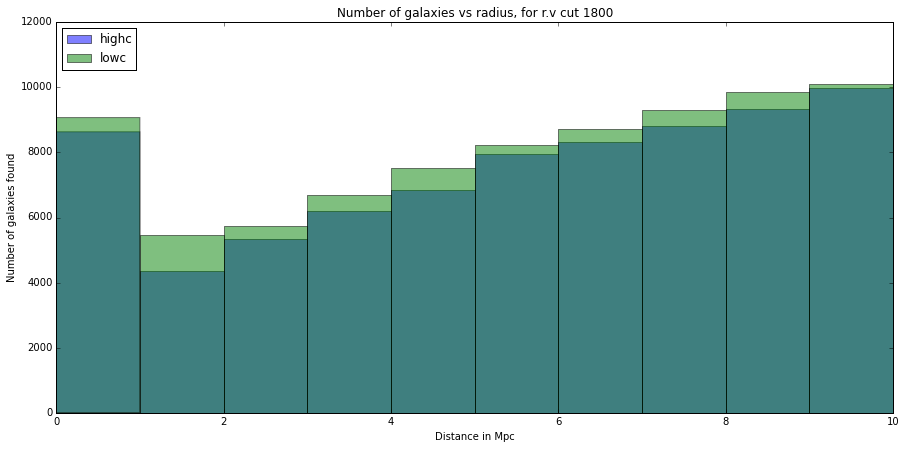

In [7]:

# number of gal as function of radius
plt.title('Number of galaxies vs radius, for r.v cut {0}'.format(radial_velocity_limit))
plt.hist(highc_concat_dists, alpha=0.5, width=1, label="highc")
plt.hist(lowc_concat_dists, alpha=0.5, width=1, label="lowc")
plt.xlabel('Distance in Mpc')
plt.ylabel('Number of galaxies found')
plt.legend(loc=2)
plt.show()

We then plot the radius vs the fractional type of galaxies found for each of the galaxies with spectral data.

Binning Info:  DescribeResult(nobs=20, minmax=(114, 19739), mean=3675.1500000000001, variance=27542269.7131579, skewness=1.9470244825019085, kurtosis=2.887421728083436)
Binning Info:  DescribeResult(nobs=20, minmax=(132, 19066), mean=3449.5, variance=25509449.631578948, skewness=1.9905658327131364, kurtosis=3.058513775667187)


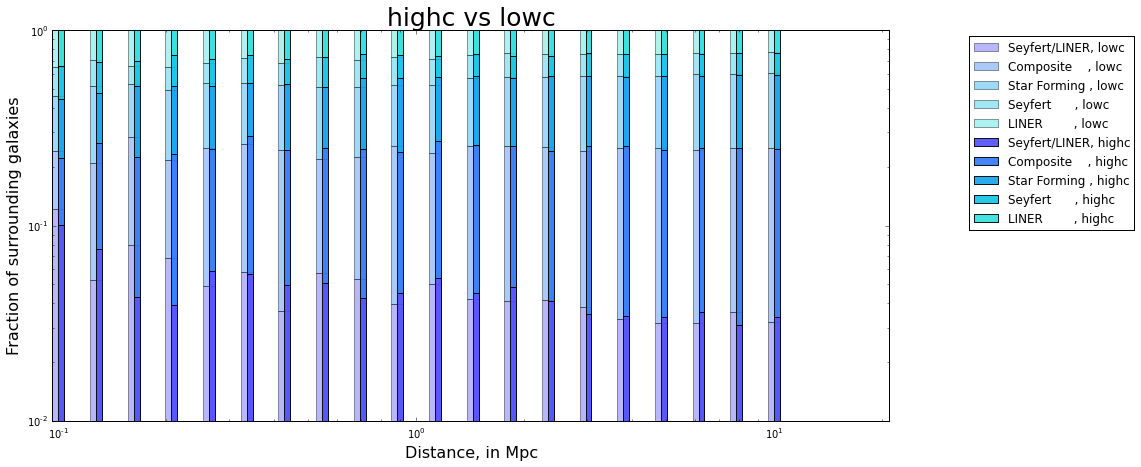

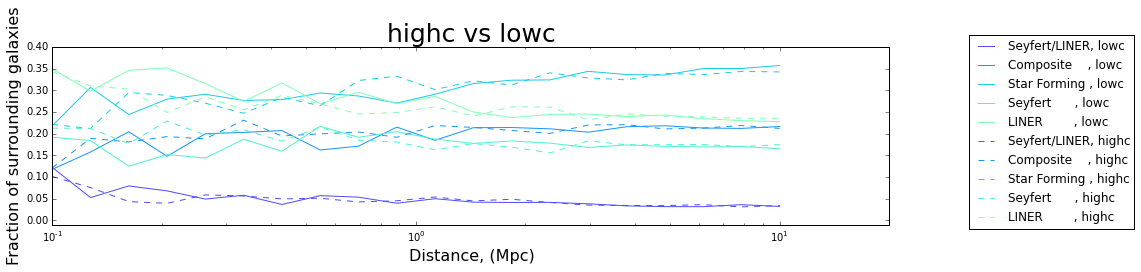

In [9]:
# plot how many galaxies we found of each type as a fraction of the total galaxies found in each radial bin 
# per input catalog

# shown in bar and line plot, with logscale toggle

log = True
number_of_bins = 20#radius

for dataset in ['lowc', 'highc']:

    if dataset == 'lowc':
        typelist = list(lowc_concat_types)
        distlist = lowc_concat_dists
        width=-0.2
        opacity = 0.4
        symb ='-'
    else: 
        width = 0.2
        typelist = list(highc_concat_types)
        distlist = highc_concat_dists
        opacity = 0.9
        symb = '--'
        
        
    string_set = list(set(typelist))
    
    # fix typos in the table
    for i in np.arange(len(typelist)):
        if typelist[i] == 'Star Fo':
            typelist[i] = 'Star Forming'
            
    bad_strings=['BLANK        ','             ','Star Fo']
    for bad_string in bad_strings:
        if bad_string in string_set: 
            string_set.remove(bad_string)
    
    # get total in each bin then weight by that
    # lines rather by histogram or stacked bar graph
    
    
    if log:
        bins = np.logspace(-1., 1., number_of_bins)
    else:
        bins = np.linspace(0, number_of_bins, number_of_bins)
    
    data_arr = [np.asarray(get_dists_of_type(string, typelist, distlist)) for string in string_set]
    which_bins = numpy.digitize(np.concatenate(data_arr), bins)
    total_count = np.bincount(which_bins)
    print('Binning Info:  {0}'.format(scipy.stats.describe(total_count)))
    bar_arr = []
    for i in np.arange(len(data_arr)):
        digitized = np.bincount(np.digitize(data_arr[i], bins))
        bar_data = [digitized[i]/total_count[i] for i in np.arange(len(total_count))]
        bar_arr.append(bar_data)
        
        
    # stacked bar graph
    bar_arr = np.asarray(bar_arr)
    bottom = np.cumsum(bar_arr, axis=0)
    barplot = plt.figure(1)
    ax = barplot.add_subplot(111)
    color=iter(cm.rainbow(np.linspace(0.1,1,16)))
    
    for i in np.arange(len(bar_arr)):
        string = string_set[i]
        data = np.asarray(bar_arr[i])
        c=next(color)
        
        
        if log:
            index = bins
            w = index/(10*np.log10(number_of_bins))
            align = 'center'
            if width >0:
                #index = index + np.log10(2)
                align = 'edge'
                w = index/(20*np.log10(number_of_bins))
                
            
        else:
            index = np.arange(1,number_of_bins+2)+width
            w = 0.45
            align= 'center'
           
        
        if i > 0:
            plt.bar(index, data, width=w, alpha=opacity, \
                    label='{0}, {1}'.format(string,dataset), color=c, bottom = bottom[i-1], align=align,log=log)
            
        else:
            plt.bar(index, data, width=w,alpha=opacity, \
                    label='{0}, {1}'.format(string,dataset), color=c, align=align, log=log)
        
    plt.title('highc vs lowc',fontsize=25)
    plt.ylabel("Fraction of surrounding galaxies", fontsize=16)
    plt.xlabel("Distance, in Mpc", fontsize=16)
    #ticks = np.arange(index.min(), index.max(), 10)
    #ax.set_xticklabels(np.round(np.arange(0,10,tmp[1])))
    #plt.xlim(-10,100)
    if log:
        plt.xscale('log')
        plt.xlim(-2,number_of_bins+1)
    else:
        plt.xlim(1,number_of_bins+2)
        plt.ylim(0,1)
        #ax.set_xticklabels(np.arange(-1,number_of_bins,2))
    
    #barplot.set_size_inches(20, 10.5)
    plt.legend(bbox_to_anchor=(1.3, 1))
    

    #barplot = plt.show()

    # line graph
    lineplot = plt.figure(2)
    line_graph = pyplot.figure(2)
    ax = line_graph.add_subplot(2,1,1)
    color=iter(cm.rainbow(np.linspace(0.1,1,10)))
    
    for i in np.arange(len(bar_arr)):
        string = string_set[i]
        data = np.asarray(bar_arr[i])
        c=next(color)
        plt.plot(index, data, label = '{0}, {1}'.format(string,dataset), color =c, linestyle=symb)
    plt.title('highc vs lowc', fontsize=25)
    plt.ylabel("Fraction of surrounding galaxies", fontsize=16)
    plt.xlabel("Distance, (Mpc)", fontsize=16)
    if log:
        ax.set_xscale('log')
        plt.xlim(0,number_of_bins)
        plt.ylim(-0.01,0.4)
    else:
        plt.xlim(0,number_of_bins)
        #ax.set_xticklabels(np.arange(-1,number_of_bins,2))
    plt.legend(bbox_to_anchor=(1.3, 1.1))
    

In [50]:
highc_df.columns

Index(['A', 'AMPLITUDE', 'AMPLITUDE_ERR', 'ANCILLARY_TARGET1',
       'ANCILLARY_TARGET2', 'AON', 'BOSS_TARGET1', 'BOSS_TARGET2', 'BPT',
       'CHISQ', 'DEC_1', 'DEC_2', 'DEC_CEN', 'EBMV', 'EBMV_ERR', 'EBMV_SFD',
       'EBOSS_TARGET0', 'ERROR_WARNING', 'EW', 'EW_ERR', 'FIBERID', 'FILENAME',
       'FIT_WARNING', 'FLUX', 'FLUX_CONT', 'FLUX_CONT_ERR', 'FLUX_ERR', 'ID',
       'ID_CEN', 'ILUM', 'IMAG', 'IMAG_ERR', 'KIND', 'LAMBDA_1', 'LAMBDA_2',
       'LAMBDA_ERR', 'LEGACY_TARGET1', 'LEGACY_TARGET2',
       'MEMBER_AVE_SEPARATION', 'MEMBER_E', 'MEMBER_THETA',
       'MEMBER_WEIGHTED_AVE_SEPARATION', 'MJD', 'MODEL_MAG', 'MODEL_MAGERR',
       'NAME_1', 'NAME_2', 'OBJID', 'PLATE', 'PZ', 'PZBINS', 'P_CEN', 'RA_1',
       'RA_2', 'RA_CEN', 'REDSHIFT', 'RUN1D', 'RUN2D', 'S', 'SIG',
       'SIGMA_STARS', 'SIGMA_STARS_ERR', 'SIG_ERR', 'SPECIAL_TARGET1',
       'SPECIAL_TARGET2', 'SPECOBJID', 'SPECPRIMARY', 'Separation', 'V',
       'VEL_STARS', 'V_ERR', 'Z', 'ZNUM', 'Z_ERR', 'Z_LAMBDA', 'Z_LA

In [ ]:
def make_line_dictionary(df_row,which_row):
    # this data has two rows and I'm not sure which is correct, so which_row is the toggle between them
    
    line_names = df_row['NAME_2'].values[which_row].split(' ')
    line_names = list(filter(None, line_names))

    new_line_names = []
    for index, line in enumerate(line_names):
        if line is None:
            continue
        line = line.split(']')
        if len(line) > 2:
            new_line = []
            for el in line:
                el = el.split('[')[-1]
                new_line_names.append(el)
            continue
        else:
            line = line[0]
        line = line.split('[')[-1]
        new_line_names.append(line)

    line_names =  new_line_names

    line_values = df_row['LAMBDA_2'].values[which_row].split('(')[1].split(')')[0].split(',')
    line_values = np.asarray([float(x) for x in line_values])


    # get flux values for the lines
    flux_values = df_row['FLUX'].values[which_row].split('(')[1].split(')')[0].split(',')
    flux_values = np.asarray([float(x) for x in flux_values])

    line_keys = list(zip(line_names, line_values))
    line_dict = dict(zip(line_keys, flux_values))

    return(line_dict)



def getBPTinfo(df, which_row):
    
    y_arr = []
    x_arr = []
    types_arr = []
    for i in np.arange(len(df)):
        df_row = df.loc[i]

        try:
            line_dict = make_line_dictionary(df_row, which_row)
        except:
            print(i)
            continue

        O3 = line_dict[('OIII', 5006.7700000000004)]
        HBeta = line_dict[('Hb', 4861.3199999999997)]
        N2 = line_dict[('NII', 6583.3400000000001)]
        HAlpha = line_dict[('Ha', 6562.8000000000002)]

        y_arr.append(O3/HBeta)
        x_arr.append(N2/HAlpha)
        types_arr.append(df_row['BPT'])
        
    return(x_arr, y_arr, types_arr)




In [ ]:
# should I chose the first or second line? 
# this data has two rows and I'm not sure which is correct, so this is the toggle between them
# this also prints out the row indices that had some error in retrieving
x, y, types = getBPTinfo(highc_df, which_row=0)


1315 A                    (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
AMPLITUDE            (0.0, 0.0, 0.0, 2.5930386, 1.8376117, 0.0, 0.4...
AMPLITUDE_ERR        (-0.0, -0.0, -0.0, 0.7917095, 0.72528833, -0.0...
ANCILLARY_TARGET1                                                    0
ANCILLARY_TARGET2                                                    0
AON                  (0.0, 0.0, 0.0, 2.1030846, 1.4906658, 0.0, 0.3...
BOSS_TARGET1                                                         0
BOSS_TARGET2                                                         0
BPT                                                              LINER
CHISQ                                                         0.904104
DEC_1                                                          23.9902
DEC_2                                                          23.9902
DEC_CEN              (23.990204, 23.99436, 23.990604, 23.956463, 23...
EBMV                                                         0.0556941
E